In [ ]:
# install transformers
!pip install transformers

In [2]:
# download data from provided link
!wget -nc https://www.dropbox.com/s/lkd0eklmi64m9xm/AirlineTweets.csv?dl=0

File ‘AirlineTweets.csv?dl=0’ already there; not retrieving.



In [3]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('AirlineTweets.csv?dl=0')

In [5]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [7]:
df = df[['airline_sentiment','text']]

<Axes: >

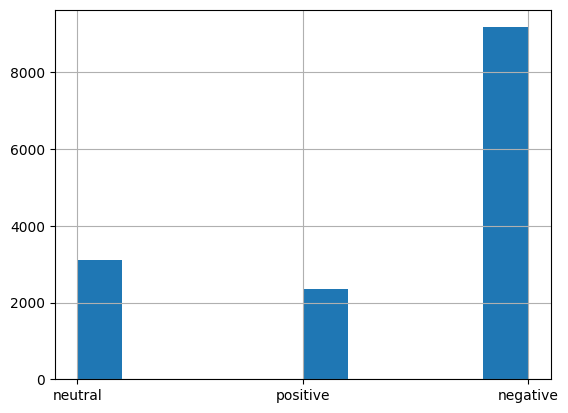

In [8]:
#Check the distribution of classes
df['airline_sentiment'].hist()

As we can see this is an imbalanced distribusion of classes. We will see if our model can handle imbalanced dataset or it will biased towards majority class.

In [9]:
target_map = { 'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

In [10]:
df1 = df[['text','target']]
df1.columns = ['sentence','label']
df1.to_csv('data.csv', index = False)

In [ ]:
!pip install datasets

In [12]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files = 'data.csv')
raw_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

 “raw_dataset = load_dataset(‘csv’, data_files = ‘data.csv’)” uses the “load_dataset” function to load a dataset stored in a CSV file named “data.csv”, which we have stored above.

In [13]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

##How to handle multiple files
`raw_dataset = load_dataset('csv', data_files = ['file1.csv','file2.csv'])`

##If we already have train test split
`raw_dataset = load_dataset('csv', data_files = { 'train': ['train1.csv','train2.csv'], 'test': 'test.csv'})`

##Tokenization

In [14]:
from transformers import AutoTokenizer
checkpoint = 'bert-base-cased'
tokernizer = AutoTokenizer.from_pretrained(checkpoint)

In [15]:
def tokenize_fn(batch):
  return tokernizer(batch['sentence'], truncation = True)

In [16]:
tokenized_dataset = split.map(tokenize_fn, batched = True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

##Choose a pre-trained model

In [17]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install torchinfo

In [20]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           2,307
Total params: 10

In [21]:
!pip install accelerate -U

In [22]:
training_args = TrainingArguments(
    output_dir='training_dir',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    )

In [23]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

In [24]:
trainer = Trainer(
    model,
    training_args,
    train_dataset = tokenized_dataset["train"],
    eval_dataset = tokenized_dataset["test"],
    tokenizer=tokernizer,
    compute_metrics=compute_metrics)

In [25]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.518500,0.412691,0.837432,0.837432
2,0.332600,0.459514,0.844718,0.844718
3,0.195500,0.670537,0.844490,0.844490


TrainOutput(global_step=1923, training_loss=0.3010827777166262, metrics={'train_runtime': 398.0124, 'train_samples_per_second': 77.244, 'train_steps_per_second': 4.832, 'total_flos': 769890416007888.0, 'train_loss': 0.3010827777166262, 'epoch': 3.0})

In [26]:
! ls training_dir

checkpoint-1282  checkpoint-1923  checkpoint-641  runs


##Evaluate the model

In [27]:
from transformers import pipeline
saved_model = pipeline('text-classification',
                       model = 'training_dir/checkpoint-1282')

In [28]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [ ]:
predictions = saved_model(split['test']['sentence'])

In [ ]:
predictions[:10]

In [ ]:
def get_label(d):
  return int(d['label'].split('_')[1])
predictions = [get_label(d) for d in predictions]
predictions

In [ ]:
print("acc:",accuracy_score(split['test']['label'], predictions))

In [ ]:
print("f1:",f1_score(split['test']['label'], predictions, average = 'macro'))

In [ ]:
# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['negative','positive','neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(split['test']['label'],predictions, normalize = 'true')
plot_cm(cm)